### **Intro**
We're going to start off by doing some data preprocessing for an emotion classifier model that takes a piece of audio data and labels it.

In [ ]:
# Libraries to install
%pip install librosa
%pip install matplotlib==3.3.4
%pip install datasets[audio]

# For colab
%pip install colabcode

In [ ]:
# Import statements
import os
import librosa
import matplotlib.pyplot as plt
import librosa.display as display
import pandas as pd

import Lib.labels as labels
import numpy as np
import soundfile as sf

In [3]:
# Let's analyze some of our audio files
audio_folder_name = "Data\SAVEE"
audio_files = os.listdir(audio_folder_name)

for file_name in audio_files[:5]:
    file_path = os.path.join(audio_folder_name, file_name)
    y, sr = librosa.load(file_path, sr=None)

    # Info about sampling rate
    print('Length of the CREMA audio files: {:.2f} seconds'.format(len(y) / sr))
    print('Number of samples: {}'.format(len(y)))
    print('Sampling rate: {} Hz'.format(sr))
    print('Checking SR again: {}'.format(librosa.get_samplerate(file_path)))

    # Extracting features
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    rms_energy = librosa.feature.rms(y=y)

    # Displaying some of the extracted features
    print("MFCCs:", mfccs)
    print("Spectral Centroid:", spectral_centroid)
    print("Chroma:", chroma)
    print("Spectral Contrast:", spectral_contrast)
    print("Spectral Rolloff:", spectral_rolloff)
    print("Zero-Crossing Rate:", zero_crossing_rate)
    print("Tempo:", tempo)
    print("RMS Energy:", rms_energy)
    print()

    # About mfccs
    # mfccs = librosa.feature.mfcc(y=array, sr=sampling_rate)
    # print(mfccs)
    # df = pd.DataFrame(mfccs)
    # print(df.head())

Length of the CREMA audio files: 3.65 seconds
Number of samples: 160868
Sampling rate: 44100 Hz
Checking SR again: 44100
MFCCs: [[-3.4192041e+02 -3.9435593e+02 -4.7589597e+02 ... -4.7595450e+02
  -4.2141251e+02 -3.5766345e+02]
 [ 1.2249877e+02  1.0463106e+02  3.2213448e+01 ...  2.8828905e+01
   8.3709961e+01  1.1964099e+02]
 [ 2.0645851e+01  3.5489052e+01  2.9343201e+01 ...  2.2902699e+01
   3.8500298e+01  2.2846634e+01]
 ...
 [ 3.8999951e+00  4.3970547e+00  5.6224837e+00 ...  3.7707844e+00
   6.2196670e+00  3.4479222e+00]
 [ 3.6335943e+00  4.6504693e+00  4.2221808e+00 ...  1.3876611e+00
   5.2211118e+00  4.6832504e+00]
 [ 3.4357426e+00  4.5474901e+00  2.9926744e+00 ... -4.2038485e-01
   2.0277987e+00  2.8178248e+00]]
Spectral Centroid: [[2552.52558988 1549.01141388  115.28987875  117.71039893  118.50355452
   116.62128293  119.5608443   120.71075055  115.55386326  117.63583719
   117.09692269  120.62337287  122.96089072  122.7982933   120.26669244
   121.29184284  115.98495713  117.70

### About Datasets
**TESS**: Sampling rate of 24 414 Hz, audio files are between 1-2 seconds long

**SAVEE**: Sampling rate of 48 000 Hz, audio files are between 3-4 seconds long

**RAVDESS**: Sampling rate of 48 000 Hz, audio files are also between 3-4 seconds long

**CREMA**: Sampling rate of 16 000 Hz, audio files 1-2 secs long

#### Testing the new labeling functions

In [2]:
dictionary = labels.SAVEE()

df = pd.DataFrame(dictionary)
print(df)

                 audio path dataset label  label
0     Data\SAVEE\DC_a01.wav             a      5
1     Data\SAVEE\DC_a02.wav             a      5
2     Data\SAVEE\DC_a03.wav             a      5
3     Data\SAVEE\DC_a04.wav             a      5
4     Data\SAVEE\DC_a05.wav             a      5
..                      ...           ...    ...
475  Data\SAVEE\KL_su11.wav            su      8
476  Data\SAVEE\KL_su12.wav            su      8
477  Data\SAVEE\KL_su13.wav            su      8
478  Data\SAVEE\KL_su14.wav            su      8
479  Data\SAVEE\KL_su15.wav            su      8

[480 rows x 3 columns]


### Data Pre-Processing - Resampling data, Generating MFCCs

In [3]:
def resample_and_normalize_data(file_path, target_sr):
    audio, sr = librosa.load(file_path)
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    audio_normalized = (audio_resampled - np.mean(audio_resampled)) / np.std(audio_resampled)
    return audio_normalized

In [19]:
# We will extract mfccs after we resample and normalize the data
def extract_mfccs(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)

    # This returns an mfcc where the COLUMNS correspond to the frames of the audio,
    # and ROWS represent features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # This extracts info about the first and second derivative of the mfcc
    # so we can get an idea of how the audio changes over time
    delta_mfcc  = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    # Stacking mfcc and deltas together
    combined_matrix = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    print("MFCC shape:", mfcc.shape)
    print("Delta MFCC shape:", delta_mfcc.shape)
    print("Delta2 MFCC shape:", delta2_mfcc.shape)

    # Normalize mfccs
    combined_matrix = (combined_matrix - np.mean(combined_matrix, axis=0)) / np.std(combined_matrix, axis=0)
    print("Combined matrix shape before transpose:", combined_matrix.shape)

    # We transpose so that the ROWS correspond to the frames of the audio, 
    # while COLUMNS represent features
    transposed_matrix = np.transpose(combined_matrix, [1, 0])
    print("Transposed matrix shape:", transposed_matrix.shape)

    # Display the combined matrix
    plt.figure(figsize=(12, 6))
    plt.imshow(combined_matrix, aspect='auto', origin='lower', cmap='viridis')

    # We divide the y-axis into three equal parts to denote MFCC, delta, and delta-delta regions
    num_rows = combined_matrix.shape[0]
    plt.yticks(
        [num_rows/6, num_rows/2, 5*num_rows/6],
        ['MFCC', 'Delta', 'Delta-Delta']
    )

    plt.title('Combined MFCC, Delta, Delta-Delta Coefficients')
    plt.xlabel('Frame')
    plt.ylabel('Coefficients')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    return transposed_matrix

In [ ]:
# Pad audio to ensure all are the same length
def pad_audio(audio, desired_length):
    # Truncate if too long
    if len(audio) > desired_length:
        audio = audio[:desired_length]

    # Else, pad with 0s
    else:
        padding = desired_length - audio
        audio = np.pad(audio, (0, padding), 'constant')

In [5]:
CREMA_dict = labels.CREMA()
RAVDESS_dict = labels.RAVDESS()
SAVEE_dict = labels.SAVEE()
TESS_dict = labels.TESS()

# Looking at one example dict
print(CREMA_dict)
df = pd.DataFrame(RAVDESS_dict)
print(df)

{'audio path': ['Data\\CREMA\\1001_DFA_ANG_XX.wav', 'Data\\CREMA\\1001_DFA_DIS_XX.wav', 'Data\\CREMA\\1001_DFA_FEA_XX.wav', 'Data\\CREMA\\1001_DFA_HAP_XX.wav', 'Data\\CREMA\\1001_DFA_NEU_XX.wav', 'Data\\CREMA\\1001_DFA_SAD_XX.wav', 'Data\\CREMA\\1001_IEO_ANG_HI.wav', 'Data\\CREMA\\1001_IEO_ANG_LO.wav', 'Data\\CREMA\\1001_IEO_ANG_MD.wav', 'Data\\CREMA\\1001_IEO_DIS_HI.wav', 'Data\\CREMA\\1001_IEO_DIS_LO.wav', 'Data\\CREMA\\1001_IEO_DIS_MD.wav', 'Data\\CREMA\\1001_IEO_FEA_HI.wav', 'Data\\CREMA\\1001_IEO_FEA_LO.wav', 'Data\\CREMA\\1001_IEO_FEA_MD.wav', 'Data\\CREMA\\1001_IEO_HAP_HI.wav', 'Data\\CREMA\\1001_IEO_HAP_LO.wav', 'Data\\CREMA\\1001_IEO_HAP_MD.wav', 'Data\\CREMA\\1001_IEO_NEU_XX.wav', 'Data\\CREMA\\1001_IEO_SAD_HI.wav', 'Data\\CREMA\\1001_IEO_SAD_LO.wav', 'Data\\CREMA\\1001_IEO_SAD_MD.wav', 'Data\\CREMA\\1001_IOM_ANG_XX.wav', 'Data\\CREMA\\1001_IOM_DIS_XX.wav', 'Data\\CREMA\\1001_IOM_FEA_XX.wav', 'Data\\CREMA\\1001_IOM_HAP_XX.wav', 'Data\\CREMA\\1001_IOM_NEU_XX.wav', 'Data\\CREMA

In [8]:
# Resample and normalize datasets
# USE: Choose target sampling rate. I went with 24 000 Hz (for emotion classification, 
# where human speech is the focus, most of the relevant information is below 8000 Hz, 
# since the human voice seldom exceeds this frequency in meaningful ways.)

# The datasets are quite large, so I recommend doing one or two at a time.
# Simply change the dataset_names and datasets variable (including the dict).

target_sampling_rate = 24000

dataset_names = ['CREMA', 'SAVEE', 'TESS']  # CHANGE THE DATASET NAME HERE!
datasets = {'CREMA': CREMA_dict, 'SAVEE': SAVEE_dict, 'TESS': TESS_dict}  # CHANGE THE DATASET NAME HERE!
dir_name = "Data/resampled"

for name in dataset_names:
    for index, audio_path in enumerate(datasets[name]['audio path']):
        audio_resampled = resample_and_normalize_data(audio_path, target_sampling_rate)

        # Making directory to store audio files
        os.makedirs(f"{dir_name}/{name}", exist_ok=True)
        path_name = f"{dir_name}/{name}/{name}_resampled_{index}_emotion_{datasets[name]['label'][index]}.wav"

        # Save audio output as wav file
        sf.write(path_name, audio_resampled, target_sampling_rate)
        librosa.get_samplerate(path_name)

C:\Users\janel\AppData\Local\Temp\ipykernel_6664\2924309022.py:4: RuntimeWarning: invalid value encountered in divide
  audio_normalized = (audio_resampled - np.mean(audio_resampled)) / np.std(audio_resampled)


In [15]:
# Now save the path name of the resampled wav files for each of the datasets
# I've separated these blocks of code since the resampling can take a while to run
# and only needs to be run once. However, each time we restart the runtime, 
# we should be running the code below to save the path name to the datset dicts

dataset_names = ['CREMA', 'RAVDESS', 'SAVEE', 'TESS']
datasets = {'CREMA': CREMA_dict, 'RAVDESS': RAVDESS_dict, 'SAVEE': SAVEE_dict, 'TESS': TESS_dict}
dir_name = "Data/resampled"

for name in dataset_names:
    datasets[name]['audio resampled path'] = []
    for index, audio_path in enumerate(datasets[name]['audio path']):
        path_name = f"{dir_name}/{name}/{name}_resampled_{index}_emotion_{datasets[name]['label'][index]}.wav"
        datasets[name]['audio resampled path'].append(path_name)
    df = pd.DataFrame(datasets[name])
    print(df)

                          audio path dataset label  label  \
0     Data\CREMA\1001_DFA_ANG_XX.wav           ANG      5   
1     Data\CREMA\1001_DFA_DIS_XX.wav           DIS      7   
2     Data\CREMA\1001_DFA_FEA_XX.wav           FEA      6   
3     Data\CREMA\1001_DFA_HAP_XX.wav           HAP      3   
4     Data\CREMA\1001_DFA_NEU_XX.wav           NEU      1   
...                              ...           ...    ...   
7437  Data\CREMA\1091_WSI_DIS_XX.wav           DIS      7   
7438  Data\CREMA\1091_WSI_FEA_XX.wav           FEA      6   
7439  Data\CREMA\1091_WSI_HAP_XX.wav           HAP      3   
7440  Data\CREMA\1091_WSI_NEU_XX.wav           NEU      1   
7441  Data\CREMA\1091_WSI_SAD_XX.wav           SAD      4   

                                   audio resampled path  
0     Data/resampled/CREMA/CREMA_resampled_0_emotion...  
1     Data/resampled/CREMA/CREMA_resampled_1_emotion...  
2     Data/resampled/CREMA/CREMA_resampled_2_emotion...  
3     Data/resampled/CREMA/CREMA_re

In [19]:
print(CREMA_dict)
print(RAVDESS_dict)
print(SAVEE_dict)
print(TESS_dict)

{'audio path': ['Data\\CREMA\\1001_DFA_ANG_XX.wav', 'Data\\CREMA\\1001_DFA_DIS_XX.wav', 'Data\\CREMA\\1001_DFA_FEA_XX.wav', 'Data\\CREMA\\1001_DFA_HAP_XX.wav', 'Data\\CREMA\\1001_DFA_NEU_XX.wav', 'Data\\CREMA\\1001_DFA_SAD_XX.wav', 'Data\\CREMA\\1001_IEO_ANG_HI.wav', 'Data\\CREMA\\1001_IEO_ANG_LO.wav', 'Data\\CREMA\\1001_IEO_ANG_MD.wav', 'Data\\CREMA\\1001_IEO_DIS_HI.wav', 'Data\\CREMA\\1001_IEO_DIS_LO.wav', 'Data\\CREMA\\1001_IEO_DIS_MD.wav', 'Data\\CREMA\\1001_IEO_FEA_HI.wav', 'Data\\CREMA\\1001_IEO_FEA_LO.wav', 'Data\\CREMA\\1001_IEO_FEA_MD.wav', 'Data\\CREMA\\1001_IEO_HAP_HI.wav', 'Data\\CREMA\\1001_IEO_HAP_LO.wav', 'Data\\CREMA\\1001_IEO_HAP_MD.wav', 'Data\\CREMA\\1001_IEO_NEU_XX.wav', 'Data\\CREMA\\1001_IEO_SAD_HI.wav', 'Data\\CREMA\\1001_IEO_SAD_LO.wav', 'Data\\CREMA\\1001_IEO_SAD_MD.wav', 'Data\\CREMA\\1001_IOM_ANG_XX.wav', 'Data\\CREMA\\1001_IOM_DIS_XX.wav', 'Data\\CREMA\\1001_IOM_FEA_XX.wav', 'Data\\CREMA\\1001_IOM_HAP_XX.wav', 'Data\\CREMA\\1001_IOM_NEU_XX.wav', 'Data\\CREMA

angry
MFCC shape: (13, 73)
Delta MFCC shape: (13, 73)
Delta2 MFCC shape: (13, 73)
Combined matrix shape before transpose: (39, 73)
Transposed matrix shape: (73, 39)


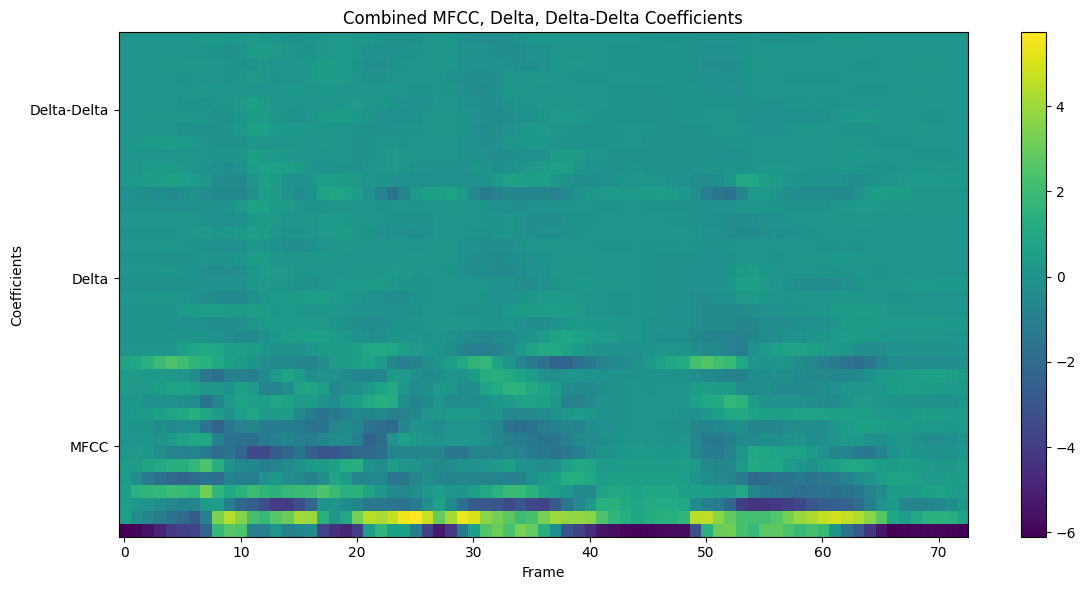

disgust
MFCC shape: (13, 113)
Delta MFCC shape: (13, 113)
Delta2 MFCC shape: (13, 113)
Combined matrix shape before transpose: (39, 113)
Transposed matrix shape: (113, 39)


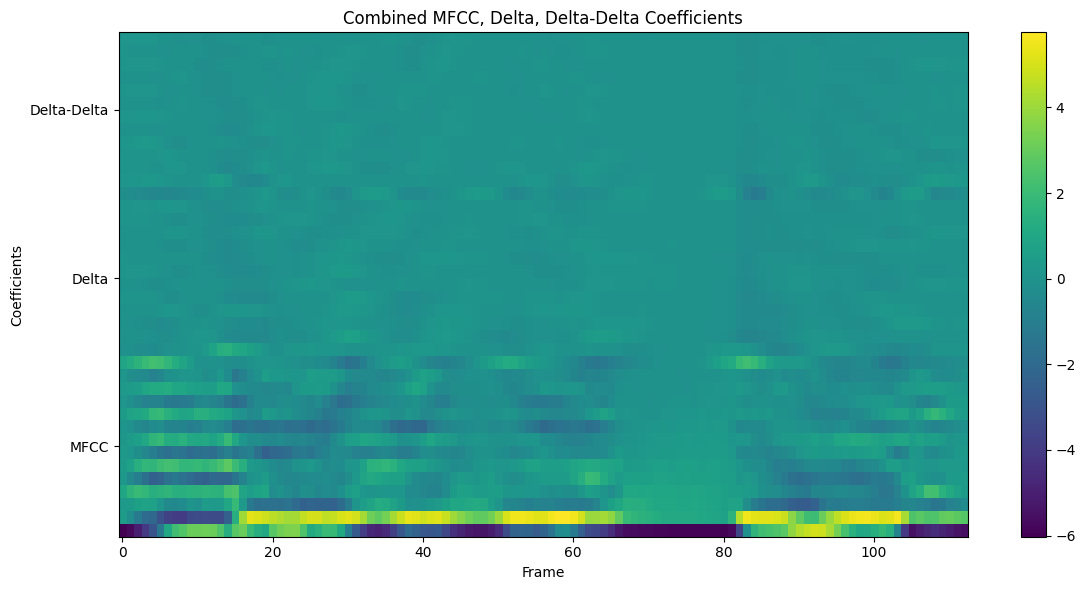

fear
MFCC shape: (13, 75)
Delta MFCC shape: (13, 75)
Delta2 MFCC shape: (13, 75)
Combined matrix shape before transpose: (39, 75)
Transposed matrix shape: (75, 39)


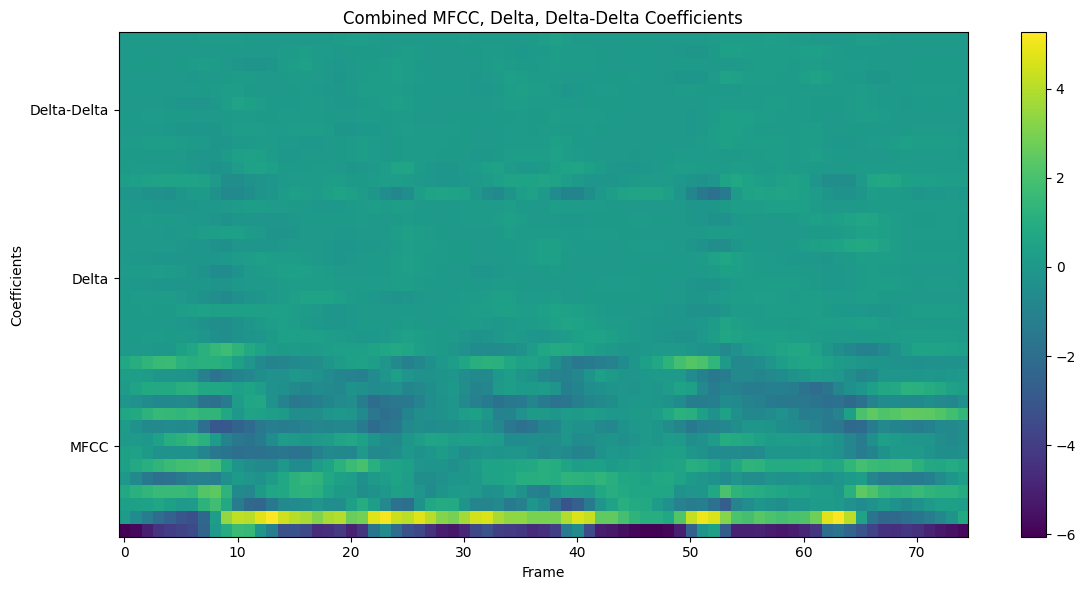

happy
MFCC shape: (13, 103)
Delta MFCC shape: (13, 103)
Delta2 MFCC shape: (13, 103)
Combined matrix shape before transpose: (39, 103)
Transposed matrix shape: (103, 39)


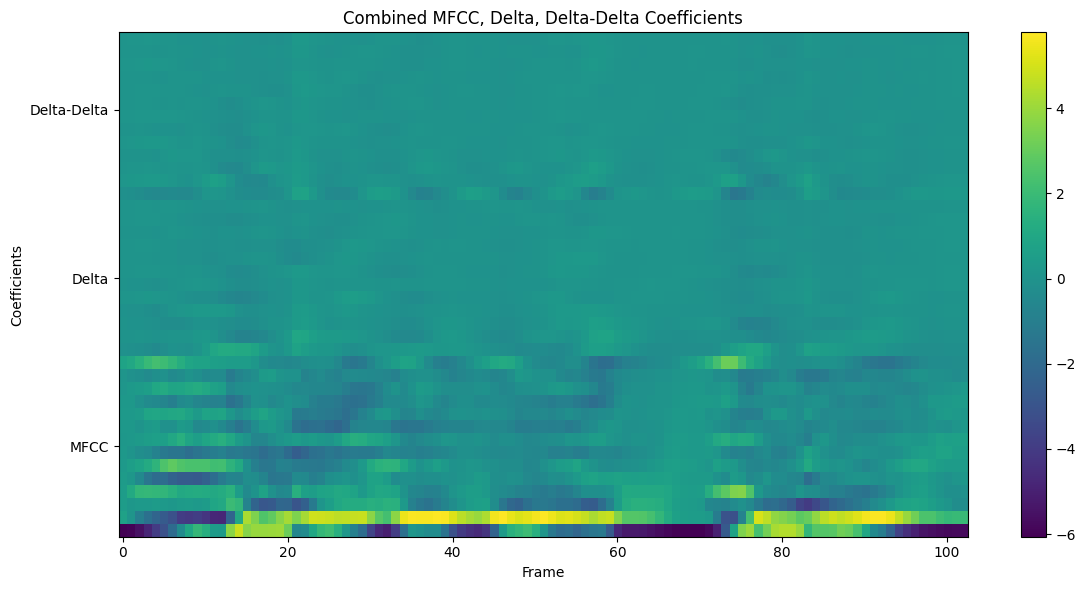

In [25]:
emotion_indices = [0, 210, 452, 647]

for emotion_index in emotion_indices:
    print(TESS_dict["dataset label"][emotion_index])
    mfccs = extract_mfccs(TESS_dict["audio resampled path"][emotion_index])

# Building the Model

In [32]:
%pip install torch torchvision scikit-learn

  Using cached torchvision-0.17.1-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.2 MB 1.7 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.2 MB 4.5 MB/s eta 0:00:01
   --------------------------- ------------ 0.8/1.2 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 7.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.8/198.6 MB 24.1 MB/s eta 0:00:09
   ---------------------------------------- 1.2/198.6 MB 15.4 MB/s eta 0:00:13
   ---------------------------------------- 2.0/198.6 MB 16.0 MB/s eta 0:00:13
    --------------------------------------- 2.8/198.6 MB 16.5 MB/s eta 0:00:12
    --------------------------------------- 3.6/198.6 MB 16.5 MB/s eta 0:00:12
    --------------------------------------- 4.4/198.6 MB 16.6 MB/s eta 0:00:12
   -


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\janel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [33]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            
        )

# TEMP: DataLoader INCOMPLETE Code (Delete later)

In [ ]:
class ResampledAudioDataset(Dataset):
    
    def __init__(self, dir):
        self.classes = {
            'neutral' : 1,
            'calm' : 2,
            'happy' : 3,
            'sad' : 4,
            'angry' : 5, 
            'fearful' : 6,
            'disgust' : 7,
            'surprised' : 8}
        self.root_dir = dir
        self.audios = self.load_audio_files()

    def load_audio_files(self):
        

    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        pass